## Download and unzip data

In [ ]:
# https://drive.google.com/drive/folders/1G83TuEQEs1Y4-ttaXxywWeARF3HzA4JL?usp=sharing

In [ ]:
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1G83TuEQEs1Y4-ttaXxywWeARF3HzA4JL' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1G83TuEQEs1Y4-ttaXxywWeARF3HzA4JL" -O data/image && rm -rf /tmp/cookies.txt

In [ ]:
# !wget 'http://www.cis.um.edu.mo/research/shelldataset//static/new_shell_images_2nd.zip'
# !wget 'cis.um.edu.mo/research/shelldataset//static/new_shell_images_2nd.zip'
# !wget --no-check-certificate 'https://drive.google.com/drive/folders/1G83TuEQEs1Y4-ttaXxywWeARF3HzA4JL?usp=sharing' -O 'data/image'

In [ ]:
# !unzip './data/new_shell_images_2nd.zip' -d 'data/image'

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import  os 
from  random import shuffle
# from tqdm import tqdm
# import cv2
import glob as glob
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16

from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D
from keras import optimizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import re
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg
import json
from keras.models import load_model

In [2]:
tf.__version__

'2.2.0'

## Initial inspection of data

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
img_dir = '/home/atlas/Atlas/Bishwa/data/image'

In [5]:
all_species = []
for y in os.listdir(img_dir):
    split = y.split('_')
    species = split[0] + ' ' + split[1]
    if species.lower() not in all_species:
        all_species.append(species.lower())


In [6]:
len(all_species)

7894

In [7]:
all_species[0]

'conus saharicus'

- As mentioned there are 7894 labels

In [8]:
im = Image.open(img_dir+'/Aandara_consociata_10_A.jpg')
print("Image size: ", im.size)

Image size:  (400, 300)


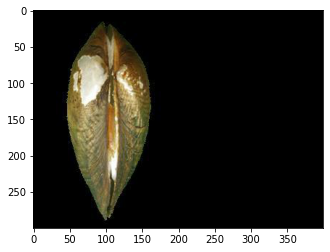

In [100]:
img=mpimg.imread(img_dir+'/Uniandra_contradens_26_B.jpg')
imgplot = plt.imshow(img)
plt.show()

## Creating dataset

In [10]:
def label_img(img):
    for y in os.listdir(img_dir):
        split = y.split('_')
        label = split[0] + ' ' + split[1]
    return label

def create_train_data():
    data = []
    for img in tqdm(os.listdir(img_dir)):
        label = label_img(img)
        path = os.path.join(img_dir,img)
        input_img = cv2.imread(path,cv2.IMREAD_COLOR)
        if input_img is not None:
            img = cv2.resize(input_img, (IMG_SIZE,IMG_SIZE))
            data.append([np.array(img), np.array(label)])
        else:
            print("image not loaded")


    shuffle(data)
    np.save('data.npy', data)
    return data

In [11]:
def create_dataframe():
    image_dict = {}
    image_dict['image'] = []
    image_dict['label'] = []
  
  # for img in tqdm(os.listdir(img_dir)):
  #   label = label_img(img)
  #   image_dict['label'].append(label)

    for imagepath in glob.glob(img_dir+'/*.jpg'):
        image = imagepath.split("/")[7]
        image_dict['image'].append(image)
        split = image.split('_')
        label = split[0] + ' ' + split[1]
#         split = image.split('.')
#         label =  split[0]
        image_dict['label'].append(label)
    df = pd.DataFrame.from_dict(image_dict)
    return df

In [12]:
for imagepath in glob.glob(img_dir+'/*.jpg'):
    image = imagepath.split("/")
    print(image)
    break

['', 'home', 'atlas', 'Atlas', 'Bishwa', 'data', 'image', 'Conus_saharicus_1_B.jpg']


In [13]:
data = create_dataframe()
data.head()

,image,label
0,Conus_saharicus_1_B.jpg,Conus saharicus
1,Schizoplax_brandtii_4_A.jpg,Schizoplax brandtii
2,Babynonia_areolata_13_B.jpg,Babynonia areolata
3,Heleobia_australis_3_B.jpg,Heleobia australis
4,Arthritica_helmsi_1_B.jpg,Arthritica helmsi


In [14]:
data.iloc[4]

image    Arthritica_helmsi_1_B.jpg
label            Arthritica helmsi
Name: 4, dtype: object

In [15]:
data.shape

(59244, 2)

In [16]:
# data.to_csv('/home/atlas/Atlas/Bishwa/data/data.csv', index = False, header=True)

In [17]:
# j = data.to_json()

In [18]:
# import json
# with open('/home/atlas/Atlas/Bishwa/data/data.json', 'w') as f:
#     json.dump(j, f)

In [19]:
len(data['label'].unique())

7894

# Filtered labels

In [43]:
df_filtered = pd.read_csv('/home/atlas/Atlas/Bishwa/data/data_greater_than_40.csv')
df_filtered.head(4)

,image,label
0,Sinanodonta_woodiana_16_A.jpg,Sinanodonta woodiana
1,Uniandra_contradens_26_B.jpg,Uniandra contradens
2,Erronea_caurica_3_A.jpg,Erronea caurica
3,Amphidromus_poecilochrous_3_A.jpg,Amphidromus poecilochrous


In [44]:
df_filtered.shape

(4582, 2)

In [45]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [51]:
train_data, valid_data = train_test_split(df_filtered, test_size=0.2,stratify=df_filtered['label'], random_state=42)

In [74]:
valid_data, test_data = train_test_split(valid_data, test_size=0.15, random_state=42)

In [75]:
# X_train, X_test, y_train, y_test = train_test_split(data['image'], data['label'], test_size=0.15,stratify=data['label'])

In [76]:
train_image_generator = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=45)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator  = ImageDataGenerator(rescale=1./255)

In [77]:
train_data_gen = train_image_generator.flow_from_dataframe(
                                                          dataframe = train_data, 
                                                          x_col = "image",
                                                          y_col = "label",
                                                          batch_size=batch_size,
                                                           directory=img_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, 
                                                           IMG_WIDTH),
                                                           class_mode='categorical',
                                                            seed=42)
train_data_gen

Found 3665 validated image filenames belonging to 71 classes.


In [55]:
label_dict = train_data_gen.class_indices

In [78]:
valid_data_gen = validation_image_generator.flow_from_dataframe(
                                                          dataframe = valid_data, 
                                                          x_col = "image",
                                                          y_col = "label",
                                                           directory=img_dir,
                                                           shuffle=False,
                                                           target_size=(IMG_HEIGHT, 
                                                           IMG_WIDTH),
                                                           class_mode='categorical')
valid_data_gen

Found 662 validated image filenames belonging to 71 classes.


In [79]:
test_data_gen = test_image_generator.flow_from_dataframe(
                                                          dataframe = test_data, 
                                                          x_col = "image",
                                                          y_col = None,
                                                           directory=img_dir,
                                                           shuffle=False,
                                                           target_size=(IMG_HEIGHT, 
                                                           IMG_WIDTH),
                                                           class_mode=None,
                                                            seed=42)
test_data_gen

Found 117 validated image filenames.


# Augumentation

In [29]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

In [30]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

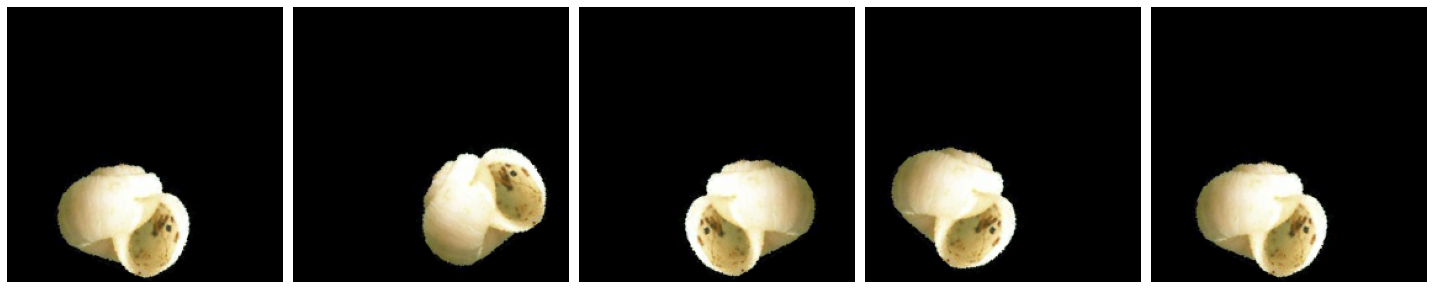

In [31]:
plotImages(augmented_images)

In [98]:
# with open('/home/atlas/Atlas/Bishwa/shell-identification-1-/src/labels/v1.02.final-label_seed_42.json', 'w') as f:
#     json.dump(label_dict, f)

## Simple baseline model

In [99]:
def model_1():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(224, 224 ,3)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(.6))
  # model.add(Dense(128, activation='relu'))
 
    model.add(Dense(7894, activation='softmax'))

    return model

In [100]:
model = model_1()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 220, 220, 64)      18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 110, 110, 64)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 108, 108, 128)     73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 54, 54, 128)       0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 27, 27, 128)      

In [101]:
model = model_1()

model.compile(loss="categorical_crossentropy",
              optimizer='adam',
              metrics=['accuracy'])

In [102]:
history = model.fit(train_data_gen,steps_per_epoch=train_data_gen.n//train_data_gen.batch_size,
                    epochs=10)
#                    validation_data=valid_data_gen,
#                    validation_steps=valid_data_gen.n//valid_data_gen.batch_size)

Epoch 1/10
370/370 [==============================] - 190s 513ms/step - loss: 8.6796 - accuracy: 0.0078
Epoch 2/10
370/370 [==============================] - 190s 515ms/step - loss: 7.4555 - accuracy: 0.0509
Epoch 3/10
370/370 [==============================] - 190s 515ms/step - loss: 6.0803 - accuracy: 0.1217
Epoch 4/10
370/370 [==============================] - 191s 515ms/step - loss: 5.0179 - accuracy: 0.1973
Epoch 5/10
370/370 [==============================] - 190s 515ms/step - loss: 4.1591 - accuracy: 0.2724
Epoch 6/10
370/370 [==============================] - 190s 515ms/step - loss: 3.4828 - accuracy: 0.3348
Epoch 7/10
370/370 [==============================] - 191s 515ms/step - loss: 2.9252 - accuracy: 0.4007
Epoch 8/10
370/370 [==============================] - 191s 515ms/step - loss: 2.4773 - accuracy: 0.4570
Epoch 9/10
370/370 [==============================] - 190s 515ms/step - loss: 2.1206 - accuracy: 0.5131
Epoch 10/10
370/370 [==============================] - 191s 515m

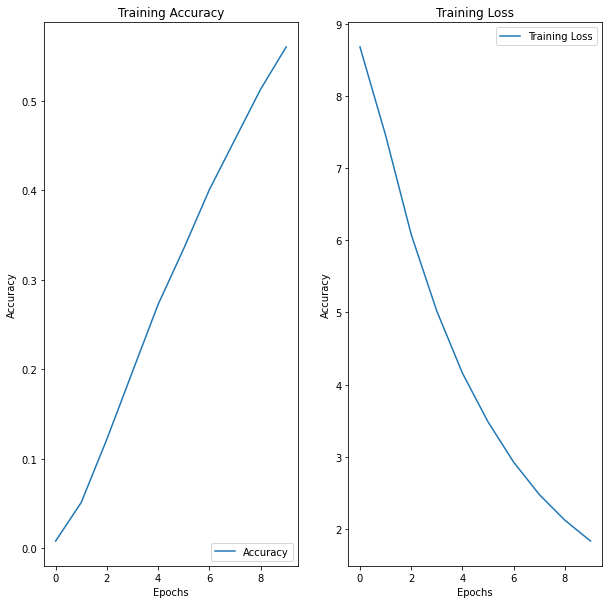

In [103]:
acc = history.history['accuracy']
loss=history.history['loss']
epochs_range = range(10)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='lower right')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# model.fit_generator(
#     train_data_gen,
#     # STEP_SIZE_TRAIN=train_data_gen.n//train_data_gen.batch_size,
#     # STEP_SIZE_VALID=valid_data_gen.n//valid_data_gen.batch_size,
#     epochs=epochs,
#     # validation_data=valid_data_gen,
#     # validation_steps=5)
# )

In [104]:
model.save('/home/atlas/Atlas/Bishwa/shell-identification-1-/models/base-model-01-10epoch_seed.h5')

In [ ]:
# model = model_1()
# model.compile(optimizers.rmsprop(lr=0.0001),
# loss="categorical_crossentropy", metrics=["accuracy"])
# STEP_SIZE_TRAIN=train_data_gen.n//train_data_gen.batch_size
# STEP_SIZE_VALID=valid_data_gen.n//valid_data_gen.batch_size
# history = model.fit_generator(generator=train_data_gen,
#                     steps_per_epoch=STEP_SIZE_TRAIN,
#                     validation_data=valid_data_gen,
#                     validation_steps=STEP_SIZE_VALID,
#                     epochs=epochs,
#                     )

In [ ]:
# model.save('model.h5')

In [ ]:
# model = model_1()
# model.compile(loss=keras.losses.categorical_crossentropy,
#               optimizer=keras.optimizers.Adadelta(),
#               metrics=['accuracy'])

# history = model.fit(X, y,
#           batch_size=batch_size,
#           epochs=epochs,
#           verbose=1,
#           )
# score = model.evaluate(x_test, y_test, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

## Trying VGG16 pretrained model

In [21]:
from keras.applications.vgg16 import VGG16


def create_model():
    model_vgg = VGG16(weights='imagenet', include_top=False,input_shape=(150,150,3))
  # flat1 = Flatten()(model.outputs)
  # class1 = Dense(1024, activation='relu')(flat1)
    for layers in model_vgg.layers:
        layers.trainable=False
        
    max_1 = MaxPooling2D(pool_size=(2,2))(model_vgg.layers[-1].output)
    flat1 = Flatten()(max_1)
    dense_1 = Dense(1024, activation='relu')(flat1)
    output = Dense(7894, activation='softmax')(dense_1)
    
    model = Model(inputs=model_vgg.inputs, outputs=output)

    return model

model = create_model()

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.001),
              metrics=['accuracy'])

model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0  

In [22]:
# history = model.fit_generator(
#     train_data_gen.flow(X, y, batch_size=batch_size),
#     steps_per_epoch=X.shape[0] // batch_size,
#     epochs=epochs,
#     # validation_data=(x_test, y_test),
#     callbacks=[ModelCheckpoint('VGG16-transferlearning.model', monitor='val_acc', save_best_only=True)]
# )
history = model.fit(train_data_gen,steps_per_epoch=train_data_gen.n//train_data_gen.batch_size,epochs=2,
                   validation_data=valid_data_gen,
                   validation_steps=valid_data_gen.n//valid_data_gen.batch_size)


Epoch 1/2
1481/1481 [==============================] - 107s 72ms/step - loss: 7.9193 - accuracy: 0.0253
Epoch 2/2
1481/1481 [==============================] - 105s 71ms/step - loss: 5.7266 - accuracy: 0.1077


In [25]:
model.save('v1.00.vgg-model.h5')

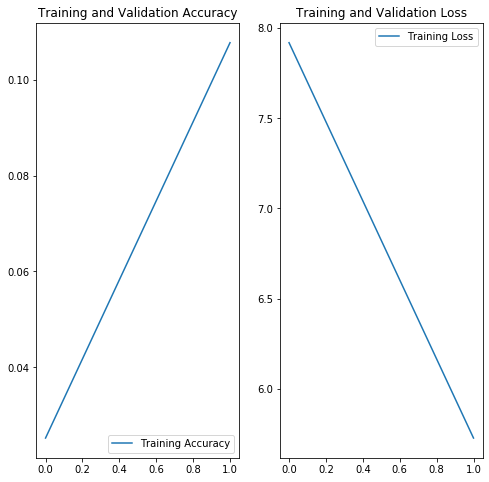

In [24]:
acc = history.history['accuracy']

# val_acc = history.history['val_accuracy']

loss=history.history['loss']
# val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Inference

In [ ]:
model = load_model('model.h5')

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

img = cv2.imread('/content/drive/My Drive/test/new_shell_images_2nd/img/Aandara_consociata_10_A.jpg')
img = cv2.resize(img,(150,150))
img = np.reshape(img,[150, 150, 1])

classes = model.predict_classes(img)

print(classes)

# Mobile net

In [69]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras import optimizers

In [80]:
class Mobile_net(Model):
    def __init__(self):
        super(Mobile_net, self).__init__()
        self.base_model = MobileNet(weights='imagenet',include_top=False, pooling="avg", input_shape=(224,224,3), dropout=0.1)
        # self.global_pool = GlobalAveragePooling2D()
        self.dense_1 = Dense(1024, activation='relu')
        self.dense_2 = Dense(512, activation='relu')
        self.dense_3 =  Dense(71, activation='softmax')

    
    def call(self, x):
        x = self.base_model(x)
        # x = self.global_pool(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        x = self.dense_3(x)
        return x

In [81]:
model_1 = Mobile_net()

In [82]:
model_1.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.001),
              metrics=['accuracy'])

In [83]:
history = model_1.fit(train_data_gen,steps_per_epoch=train_data_gen.n//train_data_gen.batch_size,epochs=15,
                      validation_data=valid_data_gen,
                   validation_steps=valid_data_gen.n//valid_data_gen.batch_size)

Epoch 1/15
28/28 [==============================] - 45s 2s/step - loss: 2.0798 - accuracy: 0.4615 - val_loss: 4.8495 - val_accuracy: 0.0766
Epoch 2/15
28/28 [==============================] - 39s 1s/step - loss: 0.6465 - accuracy: 0.7930 - val_loss: 3.0085 - val_accuracy: 0.3297
Epoch 3/15
28/28 [==============================] - 38s 1s/step - loss: 0.4303 - accuracy: 0.8671 - val_loss: 4.3574 - val_accuracy: 0.2250
Epoch 4/15
28/28 [==============================] - 32s 1s/step - loss: 0.2756 - accuracy: 0.9056 - val_loss: 3.9693 - val_accuracy: 0.2547
Epoch 5/15
28/28 [==============================] - 35s 1s/step - loss: 0.2541 - accuracy: 0.9225 - val_loss: 2.8335 - val_accuracy: 0.3609
Epoch 6/15
28/28 [==============================] - 33s 1s/step - loss: 0.1829 - accuracy: 0.9412 - val_loss: 1.6509 - val_accuracy: 0.5859
Epoch 7/15
28/28 [==============================] - 39s 1s/step - loss: 0.1940 - accuracy: 0.9344 - val_loss: 1.7937 - val_accuracy: 0.5750
Epoch 8/15
28/28 [==

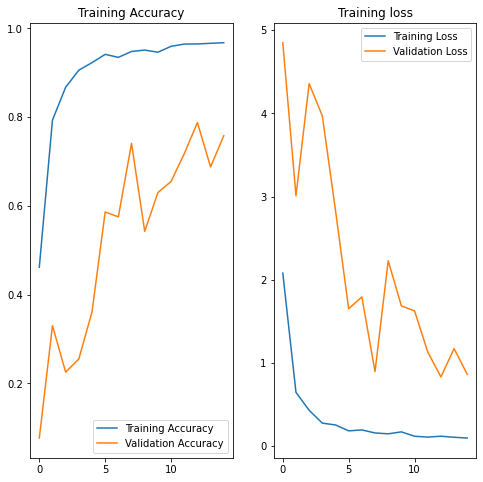

In [87]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training loss')
plt.show()

In [38]:
# type(test_data_gen)

keras_preprocessing.image.dataframe_iterator.DataFrameIterator

In [88]:
predict = model_1.predict(test_data_gen)

In [ ]:
# type(predict_indices)

In [ ]:
# predict_indices = tf.math.argmax(predict, 1)
# for i in predict_indices:
#     print(i.numpy())
#     break

In [89]:
predict_indices = tf.math.argmax(predict, 1)
# labelName = list(label_dict.keys())[label]
label_dict_inv = {v:k for k,v in label_dict.items()}

prediction = [] 

for index in predict_indices:
    prediction.append(label_dict_inv[index.numpy()])

In [90]:
from sklearn.metrics import accuracy_score, classification_report

In [91]:
print(accuracy_score(prediction, test_data['label']))

0.7264957264957265


In [92]:
print(classification_report(test_data['label'], prediction))

                           precision    recall  f1-score   support

      Albinaria corrugata       1.00      1.00      1.00         1
 Amphidromus basilanensis       0.25      1.00      0.40         1
   Amphidromus contrarius       1.00      0.50      0.67         2
  Amphidromus enganoensis       0.00      0.00      0.00         2
Amphidromus latestrigatus       0.00      0.00      0.00         0
     Amphidromus palaceus       0.75      1.00      0.86         3
    Amphidromus perversus       1.00      1.00      1.00         5
Amphidromus poecilochrous       0.00      0.00      0.00         1
     Amphidromus quadrasi       0.00      0.00      0.00         1
      Arconaia lanceolata       1.00      1.00      1.00         1
      Asperitas bimaensis       0.50      1.00      0.67         1
        Asperitas trochus       0.75      1.00      0.86         3
        Bistolida kieneri       1.00      1.00      1.00         2
        Bradybaena ravida       1.00      0.50      0.67     

/home/atlas/miniconda3/envs/atlas2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/atlas/miniconda3/envs/atlas2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [93]:
report = classification_report(test_data['label'], prediction, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv('mobile_net_filtered.csv')

In [2]:
# evaluation = model_1.evaluate(x=test_data_gen,y=test_data['label'])

In [84]:
model_1.save_weights('/home/atlas/Atlas/Bishwa/shell-identification-1-/models/v1.06.mobile-net-filtered/')

make prediction

In [56]:
model_1.load_weights('/home/atlas/Atlas/Bishwa/shell-identification-1-/models/v1.05.mobile-net-dropout/')

In [57]:
model_1.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [41]:
# !pip install opencv-python

In [94]:
from keras.preprocessing.image import img_to_array
import numpy as np
import cv2

In [98]:
img = img_dir+'/Uniandra_contradens_26_B.jpg'
image = cv2.imread(img)
image = cv2.resize(image, (224, 224))
image = image.astype("float") / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
predict = model_1.predict(image)

In [99]:
label = np.argmax(predict)
labelName = list(label_dict.keys())[label]
print("Label name:", labelName)

Label name: Uniandra contradens


In [41]:
label_dict_inv = {v:k for k,v in label_dict.items()}

In [42]:
label_dict_inv[label]

'Diodora saturnalis'

In [58]:
with open('/home/atlas/Atlas/Bishwa/shell-identification-1-/src/labels/v1.00.filtered_data', 'w') as f:
    json.dump(label_dict, f)